In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

from ffflows.models import BaseFlow
from ffflows.utils import set_trainable
from ffflows.utils import get_activation, spline_inn, get_flow4flow, get_conditional_data

from nflows.distributions import StandardNormal

from ffflows.data.conditional_plane import ScienceDataset

import yaml


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

cuda:2


In [4]:
eval_results_dir = "/global/ml4hep/spss/rrmastandrea/flows4flows/writeup2/"

# Nonconditional data

Helper functions

In [5]:
def collect_all_data_nocond(key):
    
    transported_results = {}
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/eval_data.h5")
    
    transported_results["left"] = [results_root["left_data_x"], results_root["left_data_y"]]
    transported_results["right"] = [results_root["right_data_x"], results_root["right_data_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["left_to_right_x"], results_root["left_to_right_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/eval_data.h5")
    transported_results["unidir_start"] = [results_unidir["left_data_x"], results_unidir["left_data_y"]]
    transported_results["unidir_end"] = [results_unidir["left_to_right_x"], results_unidir["left_to_right_y"]]

    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/eval_data.h5")
    transported_results["L1_start"] = [results_l1["left_data_x"], results_l1["left_data_y"]]
    transported_results["L1_end"] = [results_l1["left_to_right_x"], results_l1["left_to_right_y"]]
    
    # II
    eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    transported_results["II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
    
    # L1+II
    eval_dict_identinit = f"{eval_results_dir}/{key}_L1_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/eval_data.h5")
    transported_results["L1_II_start"] = [results_identinit["left_data_x"], results_identinit["left_data_y"]]
    transported_results["L1_II_end"] = [results_identinit["left_to_right_x"], results_identinit["left_to_right_y"]]
    
    return transported_results



In [6]:

labels_dir = {"baseline":"Baseline",
              "left":"Input",
              "right":"Target",
              "base_transfer":"Base Transfer",
              "f4f":"Flows for Flows",
              "unidir_end":"Unidirectional",
              "L1_start":"Movement Penalty",
              "L1_end":"Movement Penalty",
              "II_start":"Identity Initialization",
              "II_end":"Identity Initialization",}

# get the data

combos_identity = ["star_star", "fourcircles_fourcircles", "checkerboard_checkerboard"]
results_identity = {}

combos_transfer = ["star_fourcircles", "fourcircles_star", "fourcircles_checkerboard", "checkerboard_fourcircles",
                   "checkerboard_star", "star_checkerboard"]
results_transfer = {}

for c in combos_identity:
    results_identity[c] = collect_all_data_nocond(f"{c}_nocond")
    
for c in combos_transfer:
    results_transfer[c] = collect_all_data_nocond(f"{c}_nocond")
    



Plot each method (base, target, transfer color-coded)

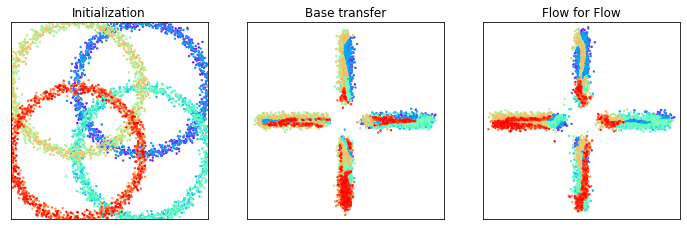

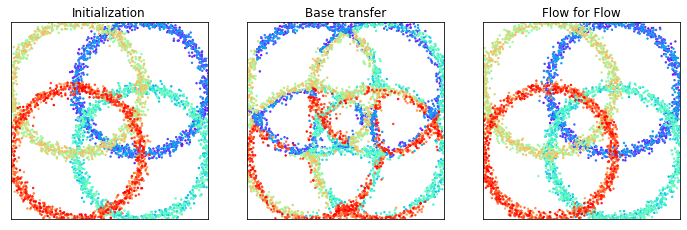

In [57]:
import matplotlib.cm as cm

def plot_color_coded_transfer(all_results_dir, combo, base_key, target_key_1, target_key_2, size = 6, b = np.linspace(-3, 3, 100), 
                              cmap = cm.rainbow, n_points = 5000, s = 2):
    
    fig, ax = plt.subplots(1, 3, figsize = (2*size, size))
    
    # we only want to plot every n_th point
    num_total_points = len(all_results_dir[combo][base_key][0])
    n_skip = int(num_total_points/n_points)
    colors = [cmap(x) for x in np.linspace(0, 1, n_points)]

    
    # input
    ax[0].scatter(all_results_dir[combo][base_key][0][:n_skip*n_points:n_skip], all_results_dir[combo][base_key][1][:n_skip*n_points:n_skip], color=colors, s = s)
    ax[0].title.set_text("Initialization")
    
    # target 1
    ax[1].scatter(all_results_dir[combo][target_key_1][0][:n_skip*n_points:n_skip], all_results_dir[combo][target_key_1][1][:n_skip*n_points:n_skip], color=colors, s = s)
    ax[1].title.set_text("Base transfer")

    ax[2].scatter(all_results_dir[combo][target_key_2][0][:n_skip*n_points:n_skip], all_results_dir[combo][target_key_2][1][:n_skip*n_points:n_skip], color=colors, s = s)
    ax[2].title.set_text("Flow for Flow")

    
    
    # axis settings
    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlim([-3, 3])
        ax[i].set_ylim([-3, 3])
        ax[i].set_aspect("equal")

    #plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/{combo}_{target_key_1}_{target_key_2}", bbox_inches="tight")
    
plot_color_coded_transfer(results_transfer, "fourcircles_star", "left", "base_transfer", "L1_end")
plot_color_coded_transfer(results_identity, "fourcircles_fourcircles", "left", "base_transfer", "L1_end")


Plot all methods

/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


0.5556515312500013
0.5513201718750013
0.5445137500000012
0.5476075781250074
2.170011046875005
0.5395636250000072
0.16954178124999855
0.1732543750000004
0.20357389062499823
0.18315462500000448
0.17696696875000043
0.18315462499999843
0.05321384375000013
0.048263718750000115
0.08353335937499927
0.6051527812499947
0.04950124999999957
0.27720700000000065


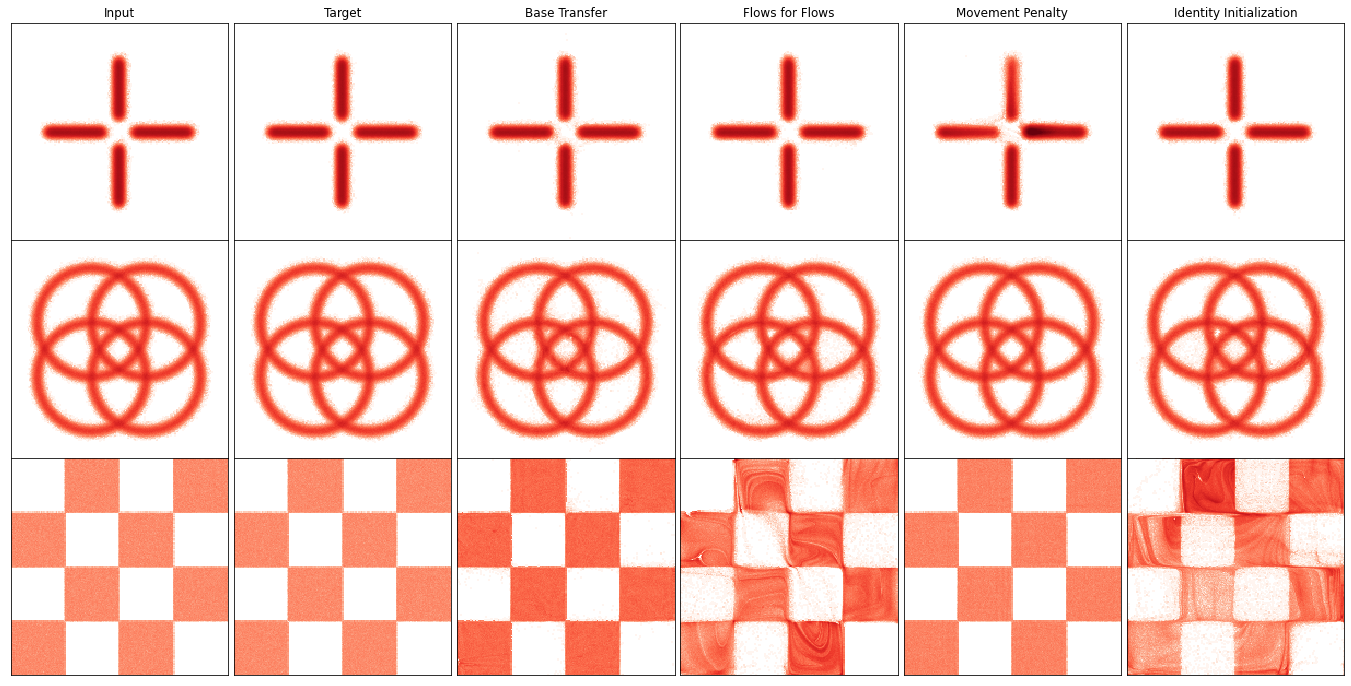

In [55]:
from matplotlib.colors import LogNorm

def plot_all_methods(keys_to_plot, combos_to_plot, all_results_dict, keyword, size = 4, b = 200, 
                              cmap = cm.Reds, l = 4):
    
    cmap.set_under("white")

    num_plots = len(keys_to_plot)
    num_combos = len(combos_to_plot)
    
    fig, ax = plt.subplots(num_combos, num_plots, figsize = (num_plots*size, num_combos*size))

    for j, combo in enumerate(combos_to_plot):
        
        for i, key in enumerate(keys_to_plot):
                        
            lll = ax[j,i].hist2d(all_results_dict[combo][key][0], all_results_dict[combo][key][1], 
                           bins = np.linspace(-l, l, b), cmap = cmap, vmax = 1.4, norm=LogNorm(),
                                 density = True)
            print(np.max(lll[0]))
            
            if j == 0:
                ax[j,i].set_title(labels_dir[key])

            # axis settings
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            ax[j,i].set_xlim([-l, l])
            ax[j,i].set_ylim([-l, l])
            ax[j,i].set_aspect("equal")

    plt.subplots_adjust(wspace=0, hspace=0)
    fig.show()
    plt.savefig(f"plots/summary_{keyword}", bbox_inches="tight")


keys_to_plot = ["left", "right", "base_transfer", "f4f", "L1_end", "II_end"]
#plot_all_methods(keys_to_plot, combos_transfer, results_transfer, "transfer")


plot_all_methods(keys_to_plot, combos_identity, results_identity,"identity")


In [25]:

    
def calculate_distance_xy(results_dir, key_1, key_2):
    # x distance
    del_xes = results_dir[key_1][0] - results_dir[key_2][0]
    # y distance
    del_yes = results_dir[key_1][1] - results_dir[key_2][1]
    
    dists = np.sqrt(del_xes**2 + del_yes**2)
    return dists


style_dict = {"baseline":["step", "black", 1, "", 2],  # step, color, alpha, hash, linewidth
             "base_transfer":["step", "#0C5DA5", 1, "", 3],
             "f4f":["stepfilled", "#00B945", 1, "", 3],
             "unidir_end":["step", "#FF9500", 1, "", 3],
             "L1_end":["step", "#FF2C00", 1, "", 3],
             "II_end":["step", "#845B97", .5, "//", 3]}




def calculate_distance_and_plot(all_results_dict, combos_to_plot, keyword, bins = 20, n_round = 3):
    
    
    distances_dict = {}
    
    
    # baseline
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "right")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["baseline"] = dists
    
    # base_transfer
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "base_transfer")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["base_transfer"] = dists
    
    # f4f
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "left", "f4f")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["f4f"] = dists
    
    # unidir
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "unidir_start", "unidir_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["unidir_end"] = dists
    
    # L1
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "L1_start", "L1_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["L1_end"] = dists
    
    # II
    dists = np.array([])
    for combo in combos_to_plot:
        loc_dists = calculate_distance_xy(all_results_dict[combo], "II_start", "II_end")
        dists = np.concatenate([dists, loc_dists])
    distances_dict["II_end"] = dists

    fig = plt.figure(figsize = (6, 6))
    for i, key in enumerate(distances_dict.keys()):
        label = labels_dir[key]
        plt.hist(distances_dict[key], bins = bins, label = label, density = True,
                            histtype = style_dict[key][0], color = style_dict[key][1],
                             alpha = style_dict[key][2], hatch = style_dict[key][3],
                 linewidth = style_dict[key][4])
        
        loc_mean = np.round(np.mean(distances_dict[key]), n_round)
        loc_std = np.round(np.std(distances_dict[key]), n_round)
        print(f"{label} & {loc_mean} & {loc_std} \\\\")
    plt.legend()

    plt.xlabel("Distance traveled")
    plt.ylabel("Density")

    plt.savefig(f"plots/distances_traveled_{keyword}")
    plt.show()
    
    

    

Baseline & 3.185 & 1.55 \\
Base Transfer & 2.37 & 1.112 \\
Flows for Flows & 3.172 & 1.523 \\
Unidirectional & 3.433 & 1.889 \\
Movement Penalty & 1.019 & 0.881 \\
Identity Initialization & 3.172 & 1.523 \\


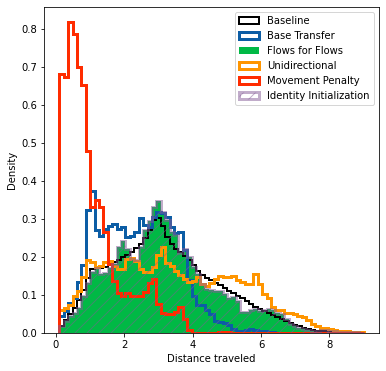

Baseline & 2.47 & 1.979 \\
Base Transfer & 2.179 & 1.443 \\
Flows for Flows & 2.234 & 1.542 \\
Unidirectional & 2.981 & 2.145 \\
Movement Penalty & 0.229 & 0.606 \\
Identity Initialization & 2.932 & 1.438 \\


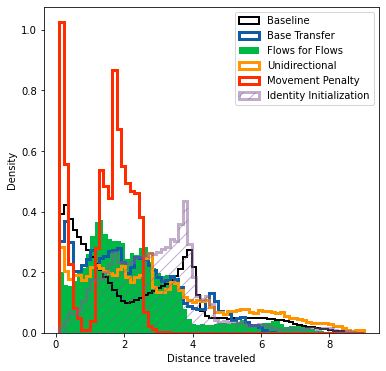

In [26]:
# calculate distances

calculate_distance_and_plot(results_transfer, combos_transfer, "transfer", bins = np.linspace(.1, 9, 70))

calculate_distance_and_plot(results_identity, combos_identity, "identity", bins = np.linspace(.1, 9, 70))

# ncond = 1

In [ ]:
eval_results_dir = "~/flows4flows/writeup2/"


def collect_all_data_yescond(key, code):
    
    transported_results = {"left":[0,0], # x, y
                           "base_transfer":[0,0],
                           "f4f":[0,0],
                           "unidir_start":[0,0],
                           "unidir_end":[0,0],
                           "L1_start":[0,0],
                           "L1_end":[0,0],
                                }
    
    eval_dict_root = f"{eval_results_dir}/{key}_f4f/"
    results_root = pd.read_hdf(f"{eval_dict_root}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    
    transported_results["left"] = [results_root["input_x"], results_root["input_y"]]

    transported_results["base_transfer"] = [results_root["base_transfer_x"], results_root["base_transfer_y"]]
    transported_results["f4f"] = [results_root["transformed_x"], results_root["transformed_y"]]
    
    # unidir
    eval_dict_unidir = f"{eval_results_dir}/{key}_inv/"
    results_unidir = pd.read_hdf(f"{eval_dict_unidir}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["unidir_start"] = [results_unidir["input_x"], results_unidir["input_y"]]
    transported_results["unidir_end"] = [results_unidir["transformed_x"], results_unidir["transformed_y"]]


    # L1
    eval_dict_l1 = f"{eval_results_dir}/{key}_L1/"
    results_l1 = pd.read_hdf(f"{eval_dict_l1}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["L1_start"] = [results_l1["input_x"], results_l1["input_y"]]
    transported_results["L1_end"] = [results_l1["transformed_x"], results_l1["transformed_y"]]

    
    # II
    eval_dict_identinit = f"{eval_results_dir}/{key}_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["II_start"] = [results_identinit["input_x"], results_identinit["input_y"]]
    transported_results["II_end"] = [results_identinit["transformed_x"], results_identinit["transformed_y"]]
    
    # L1 + II
    eval_dict_identinit = f"{eval_results_dir}/{key}_L1_identinit/"
    results_identinit = pd.read_hdf(f"{eval_dict_identinit}/flow4flow_plots/eval_data_conditional.h5", f"f4f_{code}")
    transported_results["L1_II_start"] = [results_identinit["input_x"], results_identinit["input_y"]]
    transported_results["L1_II_end"] = [results_identinit["transformed_x"], results_identinit["transformed_y"]]
    
    
    
    return transported_results


def plot_data_yescond(results_dir, size = 4):
    
    cmap = "rainbow"
    b = np.linspace(-3, 3, 100)
    

    fig, ax = plt.subplots(1, 7, figsize = (7*size, size))

    ax[0].hist2d(results_dir["left"][0], results_dir["left"][1], bins = b, cmap = cmap)
    ax[0].set_title("left data")
    
    ax[1].hist2d(results_dir["base_transfer"][0], results_dir["base_transfer"][1], bins = b, cmap = cmap)
    ax[1].set_title("base transfer")
    
    ax[2].hist2d(results_dir["f4f"][0], results_dir["f4f"][1], bins = b, cmap = cmap)
    ax[2].set_title("flow for flow")
    
    ax[3].hist2d(results_dir["unidir_end"][0], results_dir["unidir_end"][1], bins = b, cmap = cmap)
    ax[3].set_title("unidirectional") 

    ax[4].hist2d(results_dir["L1_end"][0], results_dir["L1_end"][1], bins = b, cmap = cmap)
    ax[4].set_title("f4f + L1")
    
    ax[5].hist2d(results_dir["II_end"][0], results_dir["II_end"][1], bins = b, cmap = cmap)
    ax[5].set_title("f4f + ident init")
    
    ax[6].hist2d(results_dir["L1_II_start"][0], results_dir["L1_II_end"][1], bins = b, cmap = cmap)
    ax[6].set_title("f4f + L1 + ident init")
    
        
     
    fig.show()
    

In [ ]:

# get the data
#spirals_dir = collect_all_data_yescond("checkerboard_checkerboard_rotation", "30_00")
spirals_dir = collect_all_data_yescond("checkerboard_star_rotation", "30_00")
#spirals_dir = collect_all_data_yescond("checkerboard_fourcircles_rotation", "30_00")

# plot
plot_data_yescond(spirals_dir)

In [ ]:
calculate_distance_and_plot(spirals_dir, bins = np.linspace(0, 4, 40), baseline = False)